In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("/water-quality-cleaned.csv")

In [8]:
#Missingness summary to confirm correct, cleaned, dataset is being used
missing_info = pd.DataFrame({
    "Missing Count": df.isna().sum(),
    "Missing %": (df.isna().sum() / len(df) * 100).round(2)
}).sort_values(by="Missing %", ascending=False)

print(missing_info)

                Missing Count  Missing %
pH                          0        0.0
DO                          0        0.0
Conductivity                0        0.0
Temperature                 0        0.0
Total_N                     0        0.0
Total_P                     0        0.0
Nitrate                     0        0.0
Orthophosphate              0        0.0
Year                        0        0.0
Month                       0        0.0
Season                      0        0.0


In [11]:
#checking for outliers
def plot_boxplot(df, ft):
    df.boxplot(column=[ft])
    plt.grid(False)
    plt.show()


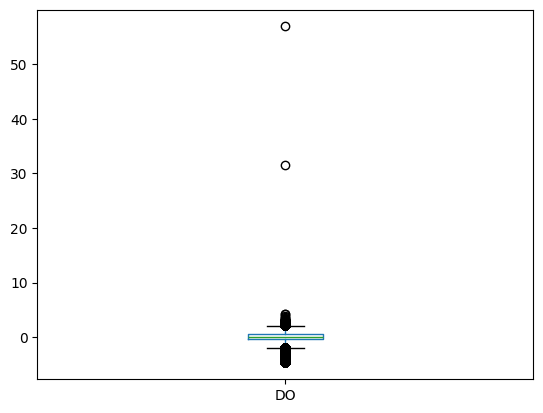

In [12]:
plot_boxplot(df, 'DO')

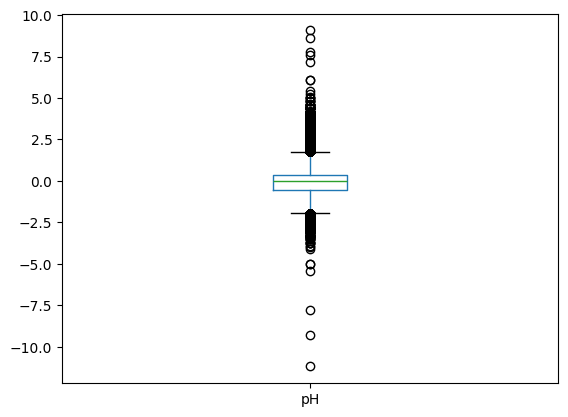

In [13]:
plot_boxplot(df, 'pH')

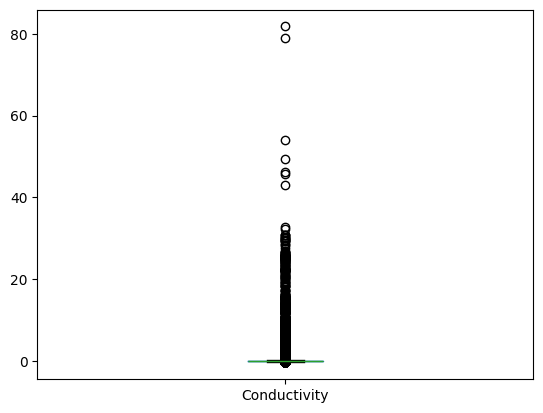

In [14]:
plot_boxplot(df, 'Conductivity')

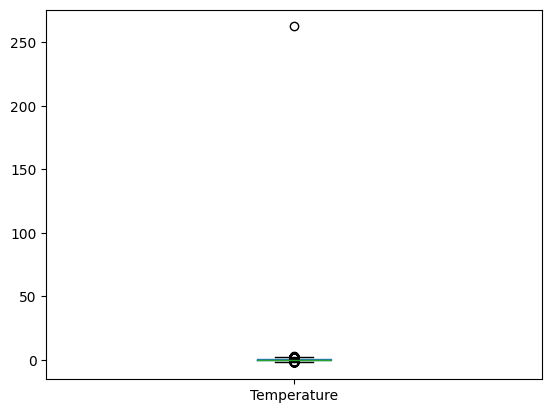

In [15]:
plot_boxplot(df, 'Temperature')

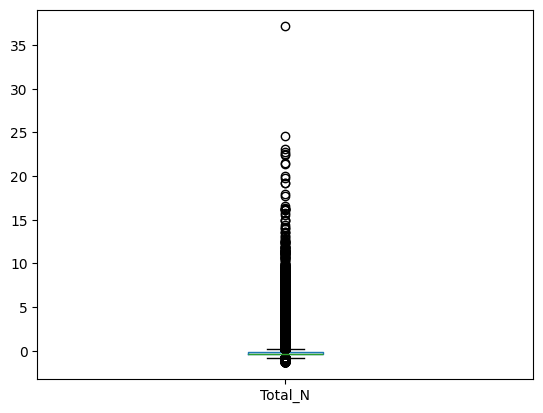

In [16]:
plot_boxplot(df, 'Total_N')

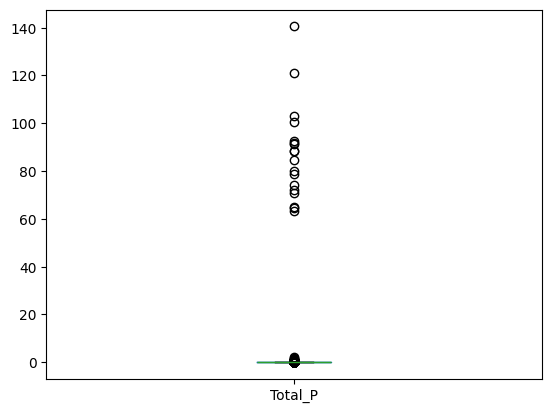

In [17]:
plot_boxplot(df, 'Total_P')

In [18]:
#Outlier removal
from sklearn.metrics import DistanceMetric as DM
from scipy.stats import f
from scipy.spatial.distance import mahalanobis

In [19]:
#use only numeric columns for covariance calculation
numeric_df = df.select_dtypes(include=np.number)

inv_cov = pd.DataFrame(np.linalg.pinv(numeric_df.cov().values), columns=numeric_df.cov().columns, index=numeric_df.cov().index)

x=numeric_df.values.tolist()
xbar=numeric_df.mean().tolist()

n=len(x)
k=len(x[0])

Hotvalue = (k * (n - 1) / (n - k))*f.ppf(0.95, k, n - k)

print(Hotvalue)


18.30883689526194


In [20]:
for i in range(0,len(x)):
  df.loc[df.index == i, 'hotelling']=(n*k)*mahalanobis(x[i], xbar, inv_cov)**2/(k*(n-k))
  df.loc[df.index == i, 'critical value']=Hotvalue

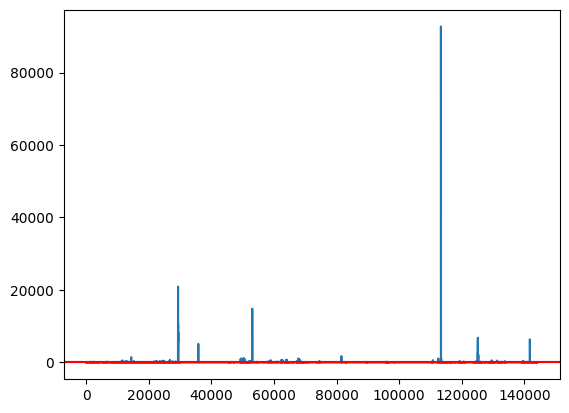

In [21]:
x=np.array(df.index.tolist())
y1=np.array(df['hotelling'])
f = plt.figure()

ax = f.add_subplot(111)


plt.plot(x, y1)
plt.axhline(y=df['hotelling'].mean())
plt.axhline(y=Hotvalue,color='r')

In [22]:
#removing outliers
df_clean = df[df['hotelling'] <= df['critical value'].iloc[0]].copy()
df_outliers = df[df['hotelling'] > df['critical value'].iloc[0]].copy()

print(df_clean.shape)
print(df.shape)
print(df_outliers.shape)


(138981, 13)
(144056, 13)
(5075, 13)


In [48]:
output_path = "water-quality-nooutliers.csv"
df_clean.to_csv(output_path, index=False)

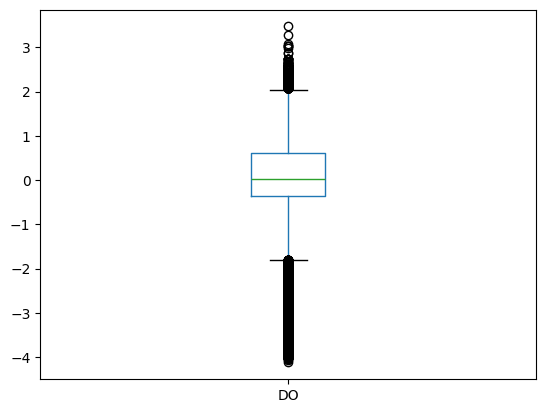

In [23]:
plot_boxplot(df_clean, 'DO')

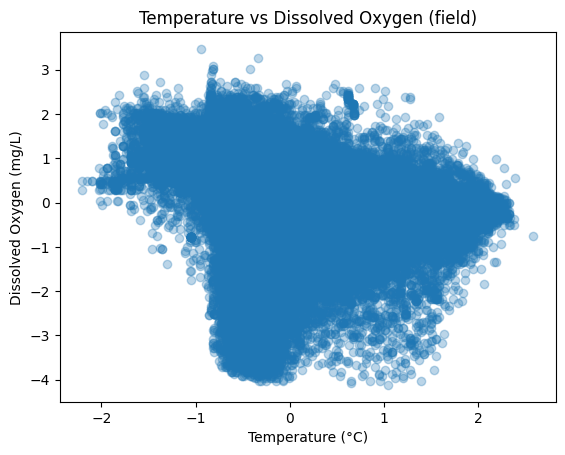

In [24]:
plt.scatter(df_clean["Temperature"], df_clean["DO"], alpha=0.3)
plt.title("Temperature vs Dissolved Oxygen (field)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.show()

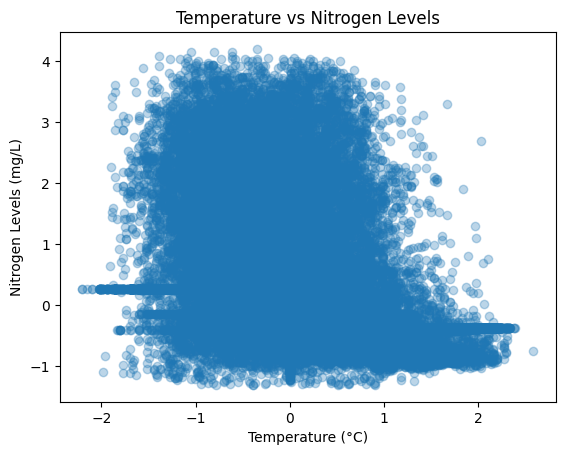

In [25]:
plt.scatter(df_clean["Temperature"], df_clean["Total_N"], alpha=0.3)
plt.title("Temperature vs Nitrogen Levels")
plt.xlabel("Temperature (°C)")
plt.ylabel("Nitrogen Levels (mg/L)")
plt.show()

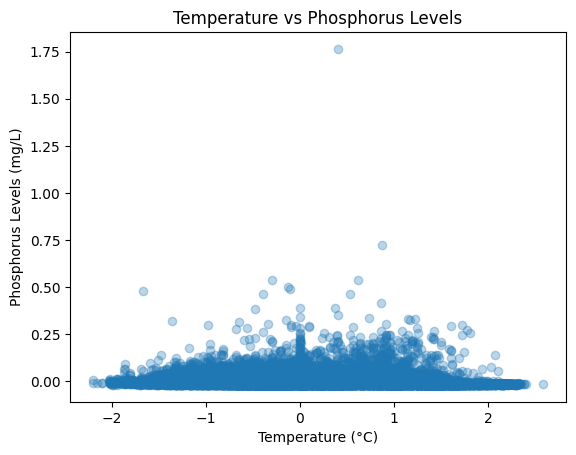

In [26]:
plt.scatter(df_clean["Temperature"], df_clean["Total_P"], alpha=0.3)
plt.title("Temperature vs Phosphorus Levels")
plt.xlabel("Temperature (°C)")
plt.ylabel("Phosphorus Levels (mg/L)")
plt.show()

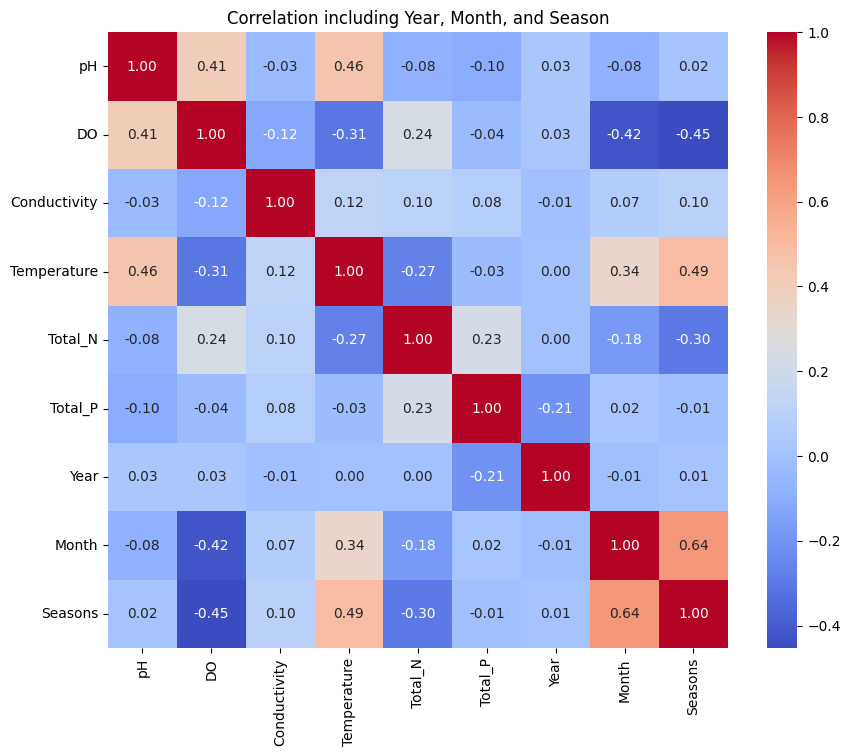

In [27]:
df_clean['Seasons'] = df_clean['Season'].map({
    'Winter': 1,
    'Spring': 2,
    'Summer': 3,
    'Autumn': 4
})

# Select columns for correlation
cols_for_corr = [
    'pH', 'DO', 'Conductivity', 'Temperature',
    'Total_N', 'Total_P',
    'Year', 'Month', 'Seasons'
]

plt.figure(figsize=(10,8))
sns.heatmap(df_clean[cols_for_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation including Year, Month, and Season")
plt.show()
#year month and season were not numeric values so had to be encoded

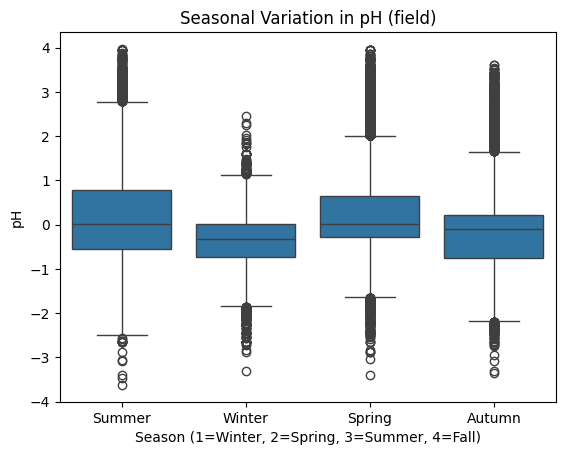

In [28]:
sns.boxplot(x="Season", y="pH", data=df_clean)
plt.title("Seasonal Variation in pH (field)")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("pH")
plt.show()

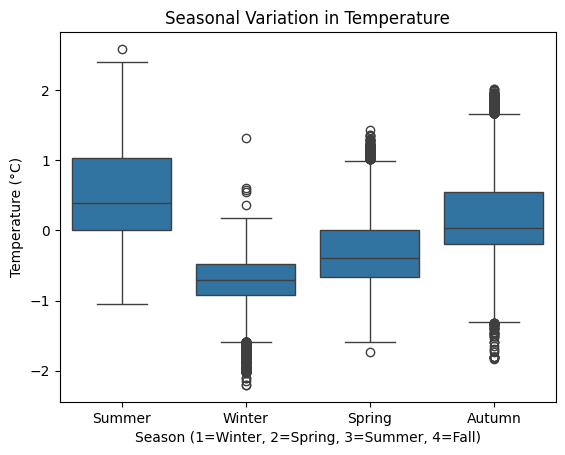

In [29]:
sns.boxplot(x="Season", y="Temperature", data=df_clean)
plt.title("Seasonal Variation in Temperature")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Temperature (°C)")
plt.show()

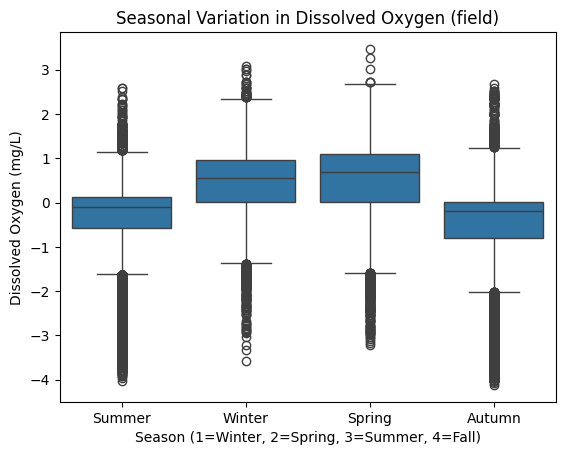

In [30]:
sns.boxplot(x="Season", y="DO", data=df_clean)
plt.title("Seasonal Variation in Dissolved Oxygen (field)")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.show()

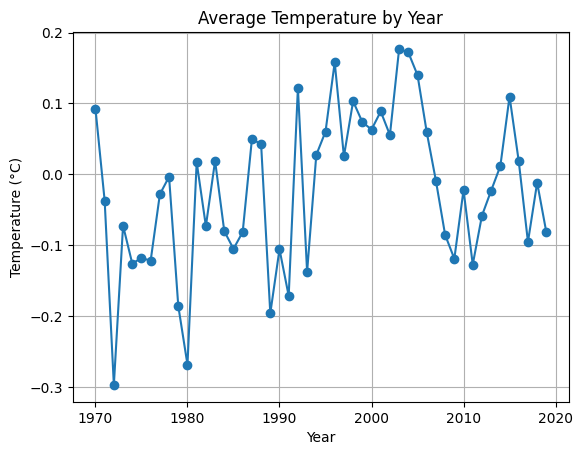

In [31]:
yearly_temp = df_clean.groupby("Year")["Temperature"].mean()

plt.plot(yearly_temp.index, yearly_temp.values, marker="o")
plt.title("Average Temperature by Year")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

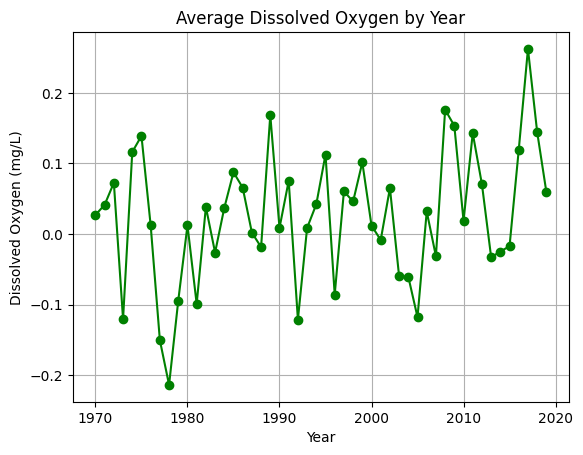

In [32]:
yearly_do = df_clean.groupby("Year")["DO"].mean()

plt.plot(yearly_do.index, yearly_do.values, marker="o", color="green")
plt.title("Average Dissolved Oxygen by Year")
plt.xlabel("Year")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.grid(True)
plt.show()


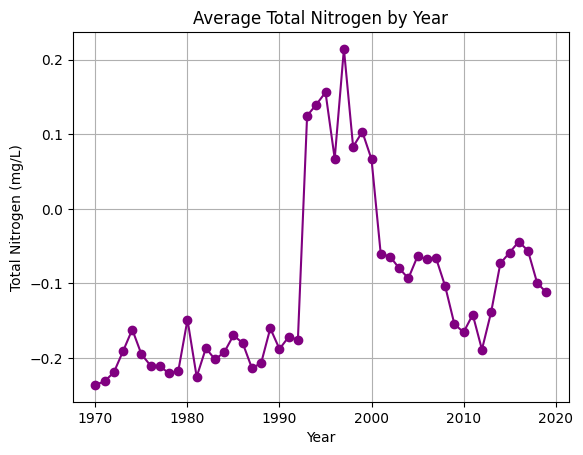

In [33]:
yearly_do = df_clean.groupby("Year")["Total_N"].mean()

plt.plot(yearly_do.index, yearly_do.values, marker="o", color="purple")
plt.title("Average Total Nitrogen by Year")
plt.xlabel("Year")
plt.ylabel("Total Nitrogen (mg/L)")
plt.grid(True)
plt.show()


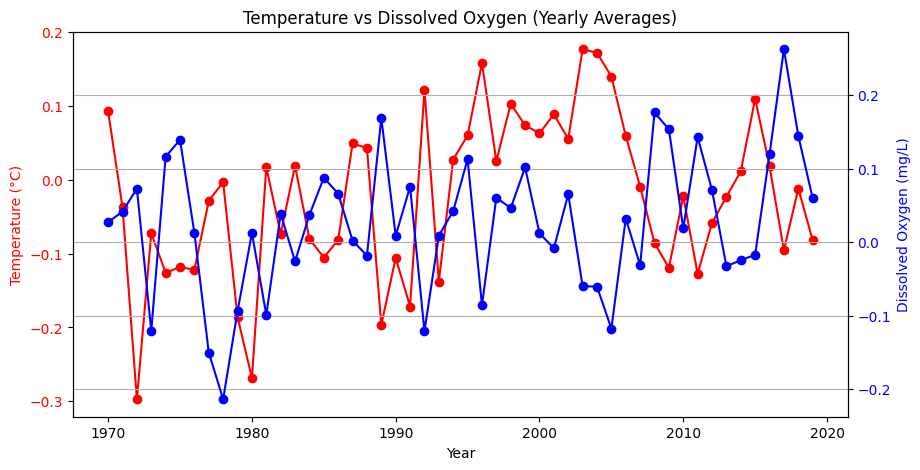

In [34]:
yearly = df_clean.groupby("Year")[["Temperature", "DO"]].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# Temperature (left axis)
ax1.plot(yearly.index, yearly["Temperature"], color="red", marker="o", label="Temperature (°C)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature (°C)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Dissolved Oxygen (right axis)
ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly["DO"], color="blue", marker="o", label="Dissolved Oxygen (mg/L)")
ax2.set_ylabel("Dissolved Oxygen (mg/L)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Temperature vs Dissolved Oxygen (Yearly Averages)")
plt.grid(True)
plt.show()

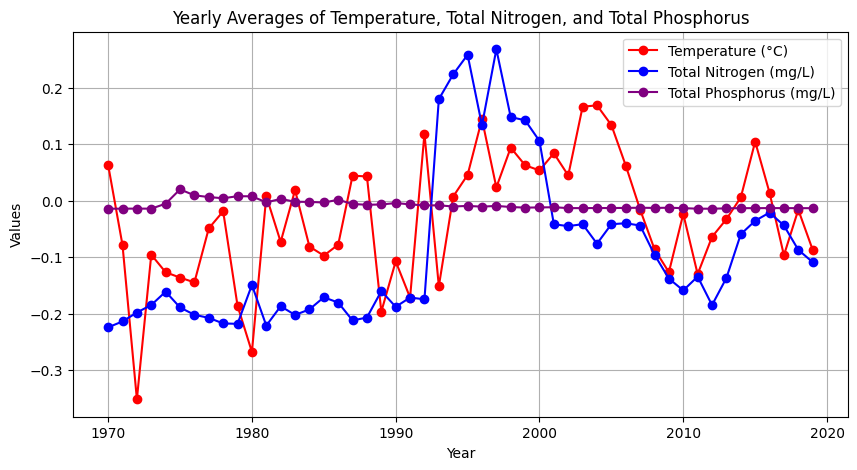

In [ ]:
yearly = df_clean.groupby("Year")[["Temperature", "Total_N", "Total_P"]].mean()

plt.figure(figsize=(10,5))
plt.plot(yearly.index, yearly["Temperature"], marker="o", label="Temperature (°C)", color="red")
plt.plot(yearly.index, yearly["Total_N"], marker="o", label="Total Nitrogen (mg/L)", color="blue")
plt.plot(yearly.index, yearly["Total_P"], marker="o", label="Total Phosphorus (mg/L)", color="purple")

plt.title("Yearly Averages of Temperature, Total Nitrogen, and Total Phosphorus")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

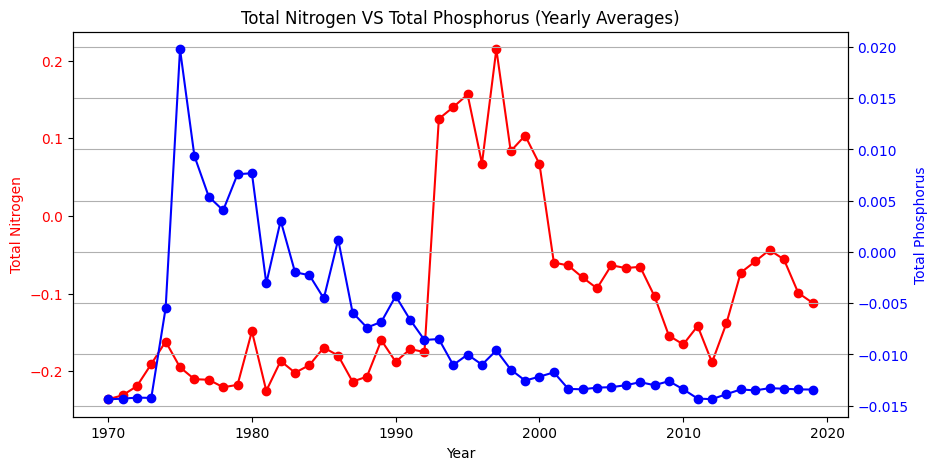

In [35]:
yearly = df_clean.groupby("Year")[["Total_N", "Total_P"]].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# Nitrogen (left axis)
ax1.plot(yearly.index, yearly["Total_N"], color="red", marker="o", label="Total Nitrogen")
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Nitrogen", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Phosphorus (right axis)
ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly["Total_P"], color="blue", marker="o", label="Total Phosphorus")
ax2.set_ylabel("Total Phosphorus", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Total Nitrogen VS Total Phosphorus (Yearly Averages)")
plt.grid(True)
plt.show()

In [36]:
#MLR analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

In [37]:
target = 'Temperature'
predictors = [
    'pH', 'DO', 'Conductivity',
    'Total_N', 'Total_P']


In [38]:
X = sm.add_constant(df_clean[predictors])
y = df_clean[target]
mlr = sm.OLS(y, X).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                 2.989e+04
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:45:32   Log-Likelihood:            -1.0167e+05
No. Observations:              138981   AIC:                         2.034e+05
Df Residuals:                  138975   BIC:                         2.034e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0402      0.002     23.505   

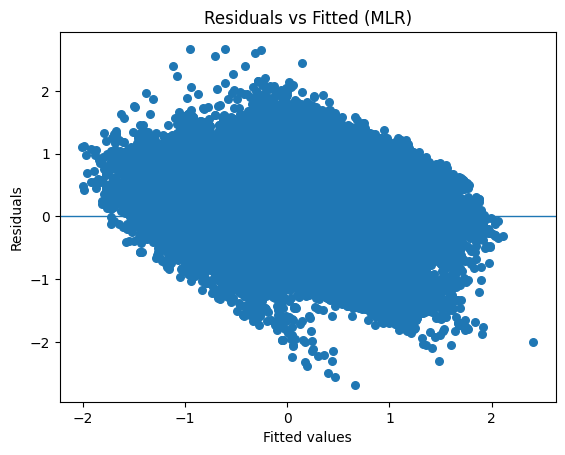

In [39]:
#residuals
fitted = mlr.fittedvalues
resid = mlr.resid

plt.figure()
plt.scatter(fitted, resid, s=30)
plt.axhline(0, linewidth=1)
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (MLR)"); plt.show()

In [40]:
#VIF
X_vif = df_clean[predictors].values
vif_vals = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
pd.DataFrame({"predictor": predictors, "VIF": np.round(vif_vals, 2)})

,predictor,VIF
0,pH,1.26
1,DO,1.36
2,Conductivity,1.09
3,Total_N,1.19
4,Total_P,1.12
